In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from pathlib import Path
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split         # Split data into train and test set

from utils import evaluate_classifier, get_sklearn_df 

# Automatically prints execution time for the individual cells
%load_ext autotime

# Automatically reloads functions defined in external files
%load_ext autoreload
%autoreload 2

# Set xarray to use html as display_style
xr.set_options(display_style="html")

# Tell matplotlib to plot directly in the notebook
%matplotlib inline  

# The path to the project (so absoute file paths can be used throughout the notebook)
PROJ_PATH = Path.cwd().parent

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 26 ms


In [7]:
netcdf_path = (PROJ_PATH / 'data' / 'processed' / 'FieldPolygons2019_stats').with_suffix('.nc')
ds = xr.open_dataset(netcdf_path, engine="h5netcdf")
ds  # Remember to close the dataset before the netcdf file can be rewritten in cells above

<xarray.Dataset>
Dimensions:         (date: 77, field_id: 67312, polarization: 3)
Coordinates:
  * date            (date) datetime64[ns] 2018-07-08 2018-07-14 ... 2019-10-31
  * field_id        (field_id) int32 61853445 61952339 ... 62131272 63199619
  * polarization    (polarization) object 'VH' 'VV' 'VV-VH'
Data variables:
    afgkode         (field_id) int16 ...
    afgroede        (field_id) object ...
    cvr             (field_id) object ...
    gb              (field_id) float32 ...
    gbanmeldt       (field_id) float32 ...
    imk_areal       (field_id) float32 ...
    journalnr       (field_id) object ...
    marknr          (field_id) object ...
    pass_mode       (date) object ...
    relative_orbit  (date) int16 ...
    satellite       (date) object ...
    stats_max       (field_id, date, polarization) float32 ...
    stats_mean      (field_id, date, polarization) float32 ...
    stats_median    (field_id, date, polarization) float32 ...
    stats_min       (field_id, date, polarization) float32 ...
    stats_std       (field_id, date, polarization) float32 ...

time: 211 ms


In [8]:
ds.close()

time: 34.3 ms


In [9]:
# Convert the xarray dataset to pandas dataframe
df = ds.to_dataframe()
df = df.reset_index()  # Removes MultiIndex
df = df.drop(columns=['cvr', 'gb', 'gbanmeldt', 'journalnr', 'marknr', 'pass_mode', 'relative_orbit'])
df = df.dropna()

time: 11.4 s


Crop types: ['Kartofler, stivelses-', 'Kartofler, lægge- (egen opformering)', 'Kartofler, andre', 'Kartofler, spise-', 'Kartofler, lægge- (certificerede)', 'Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 'Vinterbyg', 'Vårhavre', 'Vinterhybridrug', 'Vårhvede', 'Grønkorn af vårbyg', 'Vårbyg, helsæd', 'Majs til modenhed', 'Skovdrift, alm.', 'Sukkerroer til fabrik', 'Juletræer og pyntegrønt på landbrugsjord', 'Permanent græs, normalt udbytte']
Train samples:      38501
Test samples:       16501
Number of features: 231
Training time: 24.3375 s
Prediction time: 0.0066 s

Report:

Train accuracy: 1.0
Test accuracy: 0.7052

                                           precision    recall  f1-score   support

                   Kartofler, stivelses-       0.85      0.84      0.84      1396
    Kartofler, lægge- (egen opformering)       0.31      0.34      0.33       186
                        Kartofler, andre       0.26      0.29      0.27       170
                       Kartofler, spise-   

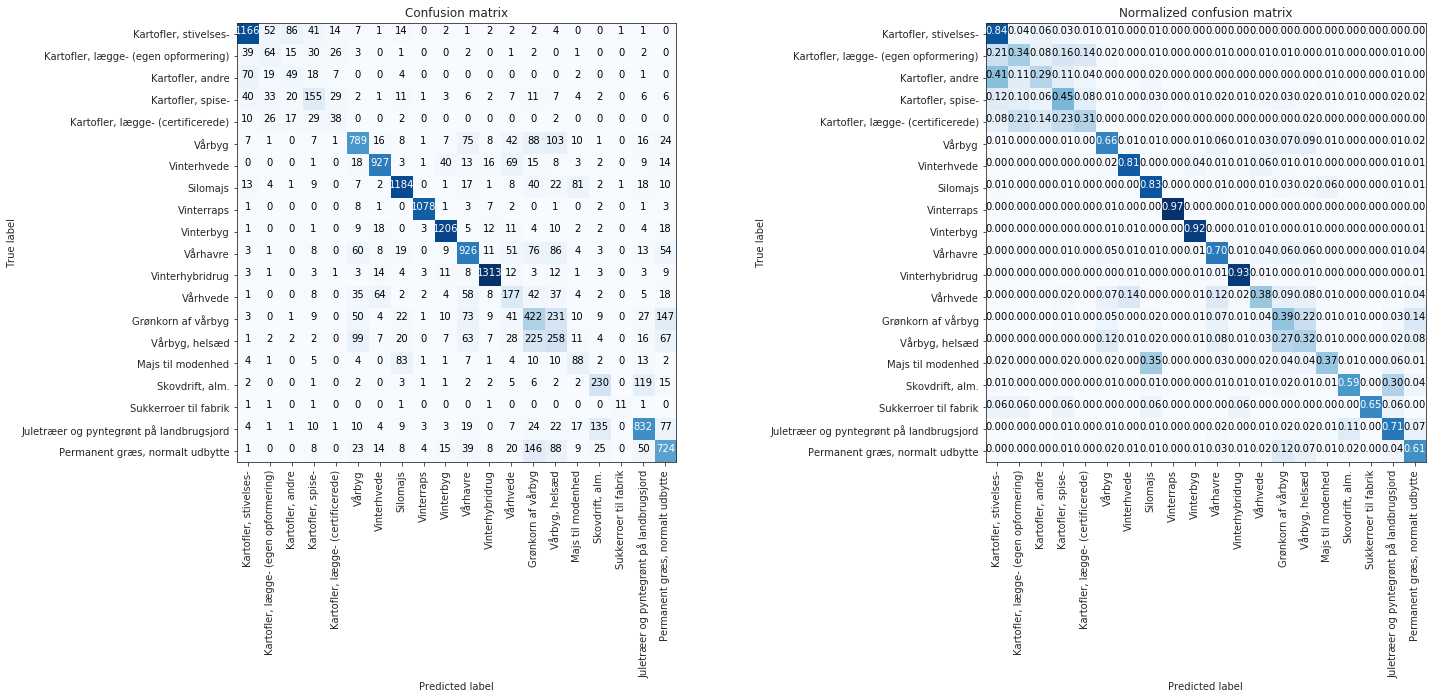

time: 1min 5s


In [15]:
df_sklearn = get_sklearn_df(polygons_year=2019, 
                            satellite_dates=slice('2018-01-01', '2019-12-31'), 
                            fields='all', 
                            satellite='all', 
                            polarization='all',
                            crop_type='all',
                            netcdf_path=netcdf_path)
    
#df_sklearn = df_sklearn[df_sklearn['afgroede'].isin(['Vårbyg', 'Vinterhvede', 'Silomajs', 'Vinterraps', 
#                                                     'Vinterbyg', 'Vårhavre', 'Vinterhybridrug'])]
crop_codes = df_sklearn['afgkode'].unique()
mapping_dict = {}
class_names = [] 

for i, crop_code in enumerate(crop_codes):
    mapping_dict[crop_code] = i
    crop_type = df_sklearn[df_sklearn['afgkode'] == crop_code].head(1)['afgroede'].values[0]
    class_names.append(crop_type)

df_sklearn_remapped = df_sklearn.copy()
df_sklearn_remapped['afgkode'] = df_sklearn_remapped['afgkode'].map(mapping_dict)
#print(f"Crop types: {class_names}")

array = df_sklearn_remapped.values

# Define the independent variables as features.
X = np.float32(array[:,3:])  # The features 

# Define the target (dependent) variable as labels.
y = np.int8(array[:,1])  # The column 'afgkode'

# Create a train/test split using 30% test size.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#print(f"Train samples:      {len(y_train)}")
#print(f"Test samples:       {len(y_test)}")
#print(f"Number of features: {len(X[0,:])}")

from sklearn.tree import DecisionTreeClassifier              

# Instantiate and evaluate classifier
clf = DecisionTreeClassifier()
clf_trained = evaluate_classifier(clf, X_train, X_test, y_train, y_test, class_names,  feature_scale=False)